In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D,Activation, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [11]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
tf.random.set_seed(42)

In [12]:
image_dir = '../input/zndmasks/images'
train = pd.read_csv('../input/zndmasks/train_labels.csv')
sub = pd.read_csv('../input/zndmasks/sample_sub_v2.csv')

In [13]:
train

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


In [14]:
sub

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


In [15]:
def create_dir(names: [str], path: str):
    """
    Creates the directories passed in the names arg list
    in the specified path within the current working directory.
    Args:
        `names`: A list of directory names to be created.
        `path`: The path where to create the directories.
    """
    for dir_name in names:
        new_dir = os.path.join(path, dir_name)
        img_path = os.path.join(new_dir)
        if not os.path.exists(img_path):
            os.mkdir(img_path)
        else:
            print(f'{img_path}: Exists!') 


def move_images(image_list: [str], source_dir: str, dest_dir: str):
    """
    Move images in image_list from source path to dest path.
    Args:
        `image_list`: A list of image files to be moved between directories.
        `source_dir`: The source/current directory holding the files.
        `dest_dir`: The new directory where the files will be transfered.
    """
    for img in image_list:
        shutil.move(source_dir+img, dest_dir)

Creating train and test directories to store the respective images:

In [17]:
dirs = ['train', 'test']
#create_dir(dirs, '/kaggle/working/')
create_dir(dirs, '/tmp/')

/tmp/train: Exists!
/tmp/test: Exists!


In [18]:
img_names = os.listdir('../input/zndmasks/images')
train_img_names = train.image.tolist()
test_img_names = []

for img in img_names:
    if img not in train_img_names:
        test_img_names.append(img)
        
train_img_names
test_img_names

['sfpwptgynidjmylpqeukgkhzqcitgm.jpg',
 'lwhltrzhopzxcxkmjnepvkfkuocyyf.jpg',
 'unkvelhemzsndcplwwcplvzhztcllz.jpg',
 'wcnsyehazqxgakcdbtyehtkwoiwppj.jpg',
 'urdgcrihebtothfemyxubtwpinualu.jpg',
 'ivhqllncotctfxttkqqvwamkdeokih.jpg',
 'weipwizxckxeagywuilohlxktcrypk.jpg',
 'volxwqaiygijoxnemgujucdvaxcmla.jpg',
 'plyaiuqsdfyiowewiorerysaomwoum.jpg',
 'hddqpruzeyfpuemmkrvajzewjauqbg.jpg',
 'tbjzvqedthirsztsnsjkfrdgroofmt.jpg',
 'yurmkbqrwlidqgbgeeszgsuzzizhtv.jpg',
 'nkexoipjsbhmytzjsnvxpkqhdtqidv.jpg',
 'lmdcsyqhjxxvdfzakuhxxmcrwmqkjj.jpg',
 'jjqgfnkunxqxwlrjxgakwcukfoavym.jpg',
 'utjaezxnmbadaiqjqgkmdmfdzqozqr.jpg',
 'jvcaprbropasegknsisprgwgitcrpi.jpg',
 'orsoixyrasfxlkqzngwfasbadeydlh.jpg',
 'tqtohrbvnjhvqqpkcpqxihkomlzddz.jpg',
 'hirjzqktwfoauvblgqocpnrhksqdih.jpg',
 'fnefuqqsicuqfsymibosjdjwawrmvq.jpg',
 'hdftlvovpcycpipsqjnfxbzuvmlnlm.jpg',
 'ioafahyushqhdpfinjvuormfkchmjf.jpg',
 'imzjoogcbcvsgkbekgsxdfhxdlodgb.jpg',
 'yklgcnlafkcgjozrkuzbebbsggluus.png',
 'nncgaofbnlhkcvnvhajmgrx

In [19]:
print(len(train_img_names))
print(len(test_img_names))

1308
509


In [20]:
from distutils.dir_util import copy_tree

fromDirectory='../input/zndmasks/images'
toDirectory='/tmp/images'

copy_tree(fromDirectory,toDirectory)

['/tmp/images/gvpxmmxppqjudjgopzedpjxypiptvv.jpg',
 '/tmp/images/sfpwptgynidjmylpqeukgkhzqcitgm.jpg',
 '/tmp/images/gmquckbspnnynsvwiuprdeuutxcwzy.jpg',
 '/tmp/images/bxazgghixladgkjuctwbbplfusnmuz.jpg',
 '/tmp/images/eijlcxndtcvdunbcfsyskzeecytlnt.jpg',
 '/tmp/images/lwhltrzhopzxcxkmjnepvkfkuocyyf.jpg',
 '/tmp/images/pueoruxicpinrqmhckieebldxnjkyd.jpg',
 '/tmp/images/uceyzrlbtdzbqhiousxplkcrbpmrek.jpg',
 '/tmp/images/unkvelhemzsndcplwwcplvzhztcllz.jpg',
 '/tmp/images/wkpckjtijsxyrygjqwnmrfregbebln.jpeg',
 '/tmp/images/wcnsyehazqxgakcdbtyehtkwoiwppj.jpg',
 '/tmp/images/urdgcrihebtothfemyxubtwpinualu.jpg',
 '/tmp/images/ivhqllncotctfxttkqqvwamkdeokih.jpg',
 '/tmp/images/lwmdzzsaiixwqpkenspvmwbagjihmt.jpg',
 '/tmp/images/weipwizxckxeagywuilohlxktcrypk.jpg',
 '/tmp/images/volxwqaiygijoxnemgujucdvaxcmla.jpg',
 '/tmp/images/plyaiuqsdfyiowewiorerysaomwoum.jpg',
 '/tmp/images/hddqpruzeyfpuemmkrvajzewjauqbg.jpg',
 '/tmp/images/wfrljvnhcchkfxboqpadkaumbaktor.jpg',
 '/tmp/images/iurrhmjxbxceorfa

In [21]:
# Move train images to the train dir
move_images(train_img_names, '/tmp/images/', '/tmp/train/')

# Move test images to the test dir
move_images(test_img_names, '/tmp/images/', '/tmp/test/')

Text(0, 0.5, 'Number of images in train set')

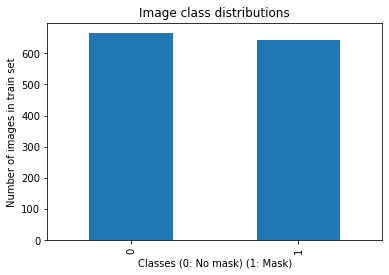

In [22]:
# Plotting the image class distributions in the train set
train['target'].value_counts().plot.bar()
plt.title('Image class distributions')
plt.xlabel('Classes (0: No mask) (1: Mask)')
plt.ylabel('Number of images in train set')

In [23]:
# Further splitting the train images into train and validation images.
train['target'] = train['target'].replace({0: 'No_mask', 1: 'Mask'})

tr_data, val_data = train_test_split(train, test_size=0.20, random_state=42)
tr_data = tr_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [24]:
tr_data

,image,target
0,cxcbhkudpsisssjflxuagoxflcoxnk.jpg,Mask
1,gvryvlubplzelzmzewqhwohzqtljdw.jpg,Mask
2,hpurkuyxligdvrhgbtibxzbmkbvvzc.jpg,No_mask
3,qvqhxwbgpskanqpsfbigdmbpkenvgk.jpg,No_mask
4,sylgsucyayhotkvwdqjbmlanzvsrym.jpg,Mask
...,...,...
1041,uqemxrpkidnoqugrinhsjfvxsftqeu.jpg,Mask
1042,kvmbftolilmezbrtktattngwlqxond.jpg,Mask
1043,llzvwiafucclynnqdfdelujavtdbku.jpg,Mask
1044,wwsgrddjsqazdybqxotetodwmhfwro.jpg,Mask


In [25]:
total_train = tr_data.shape[0]  #total train images
total_validate = val_data.shape[0] #total images on validation set
batch_size = 8

In [26]:
# Train generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    tr_data, 
    '/tmp/train/', 
    x_col = 'image',
    y_col = 'target',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

# Validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val_data, 
    '/tmp/train/', 
    x_col='image',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1046 validated image filenames belonging to 2 classes.
Found 262 validated image filenames belonging to 2 classes.


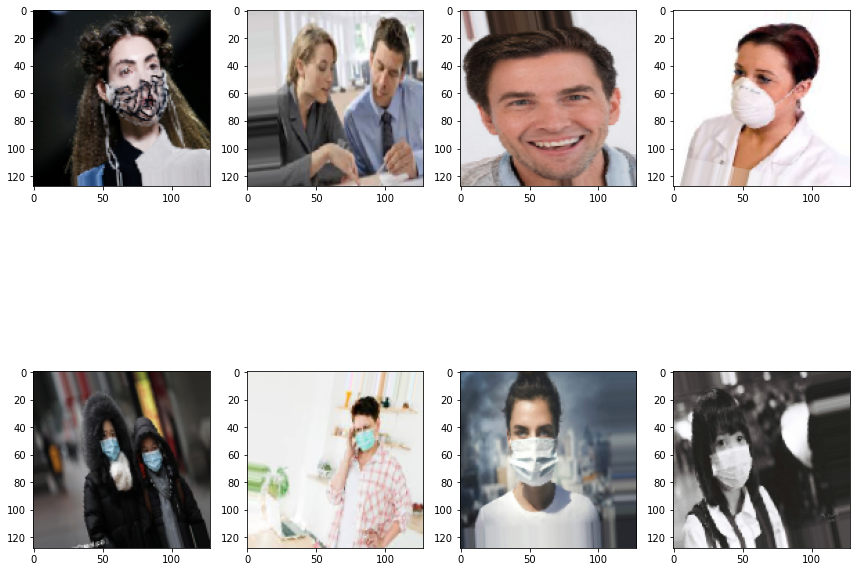

In [27]:
plt.figure(figsize=(12, 12))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [62]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                                               include_top=False,
                                               weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x =  Dense(1024,activation='relu')(x) # complex for better results.
x = Dropout(0.8)(x) 
x = Dense(1024,activation='relu')(x) 
x = Dropout(0.8)(x) 
x = Dense(512,activation='relu')(x) 
x = Dropout(0.8)(x) 
preds = Dense(2,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [63]:
earlystop = EarlyStopping(patience=5) # Stop if validation loss doesn't improve after 5 epochs

# Gradually reduce the learning rate if validation loss doesn't improve after 5 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                           )
modelcheckpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [earlystop, modelcheckpoint,learning_rate_reduction]

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
# Training the model
epochs = 10 if FAST_RUN else 100

history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/100
130/130 [==============================] - 53s 409ms/step - loss: 2.1341 - accuracy: 0.5183 - val_loss: 0.6434 - val_accuracy: 0.5742 - lr: 1.0000e-04
Epoch 2/100
130/130 [==============================] - 51s 389ms/step - loss: 1.7543 - accuracy: 0.5347 - val_loss: 0.6244 - val_accuracy: 0.5781 - lr: 1.0000e-04
Epoch 3/100
130/130 [==============================] - 51s 389ms/step - loss: 1.5442 - accuracy: 0.5058 - val_loss: 0.6297 - val_accuracy: 0.5781 - lr: 1.0000e-04
Epoch 4/100
130/130 [==============================] - 54s 416ms/step - loss: 1.3231 - accuracy: 0.5347 - val_loss: 0.6328 - val_accuracy: 0.5508 - lr: 1.0000e-04
Epoch 5/100
130/130 [==============================] - 53s 405ms/step - loss: 1.1272 - accuracy: 0.5472 - val_loss: 0.5900 - val_accuracy: 0.6328 - lr: 1.0000e-04
Epoch 6/100
130/130 [==============================] - 53s 406ms/step - loss: 0.9938 - accuracy: 0.5462 - val_loss: 0.5822 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 7/100
130/130 [=

In [65]:
model.save_weights("mobilenet.h5")

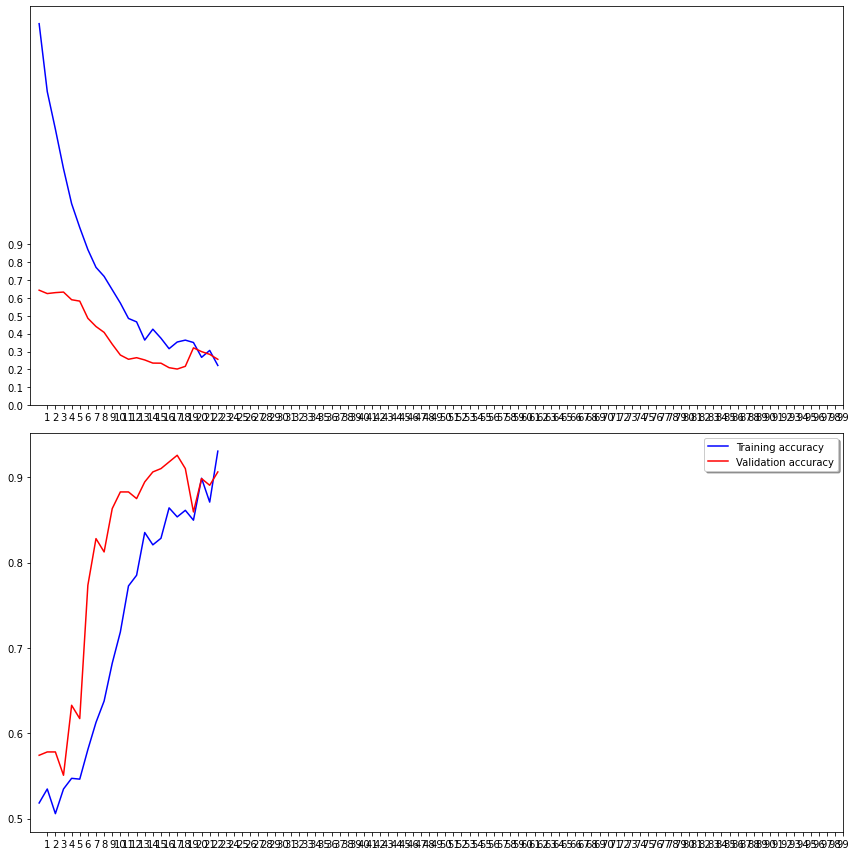

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [67]:
test_filenames = os.listdir('/tmp/test/')
test_df = pd.DataFrame({
    'image': test_filenames
})
nb_samples = test_df.shape[0]

In [68]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/tmp/test/', 
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 509 validated image filenames.


In [69]:
predictions = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [70]:
predicted_probabilities = predictions.max(1)

In [71]:
test_df['target'] = predicted_probabilities

In [72]:
test_df

,image,target
0,pcoalfrhngfbattlzqaljgpzrmdiby.jpg,0.819854
1,ufhysrqbbzlrqymeekhvxkoqeyxbyo.jpg,0.959780
2,vwqrhobzdutxipuwgssuzjbhxumbod.jpg,0.660651
3,jwdjkvvfvggphwhqatmbkjjlzdienf.jpg,0.996924
4,jjqgfnkunxqxwlrjxgakwcukfoavym.jpg,0.996867
...,...,...
504,yegdjxoapgowmbnvlrdryvaecnynya.jpg,0.999812
505,uzfesehhvhqxuziizqgipuqbvjkarm.jpg,0.865859
506,csrqrzoyceubuehyicuwjisnsvyfuk.jpg,0.689140
507,gvzjodvhueivloxnomfhmpmcdbzvap.jpeg,0.771389


In [73]:
sub = test_df.copy()
sub.to_csv('submission.csv', index=False)